# Assignment 1: ODrive setup and initial kinematics exploration

In homework 1 we will learn the basic functionality of the ODrive motor controller and the kinematics of the 5-bar leg. There are 5 problems below. You will turn this assignment in by uploading it to your own github repository for this assignment and then sending a link to ngravish@eng.ucsd.edu with the subject MAE_207_HW1. The assignment is to be completed in pairs, one per team.

If you would like, you directly ```fork``` this repository into your github account, this is found in the upper right hand corner. You can then download the repository to your computer using the ```clone``` button on the right side. Once you are done with the assignment, commit the changes back to the github online repository. 

Alternatively you can just download the .ipynb file, edit it as you solve the problems, and then in the end upload to a github repo.

Team #:

Names: Kristoffer Borgen Knudsen, U07665240



## Problem 1: Familiarization with ODrive firmware

__1.1__ You should follow the instructions to flash the motor controller firmware found [here](https://github.com/madcowswe/ODrive).

__1.2__ In the ```Odrive/Firmware/MotorControl``` folder are the code files that control the motor. The most important file is ```low_level.c```. Find this file and familiarize yourself with it. 

__1.3__ In ```low_level.c``` the main function for motor control is ```control_motor_loop(Motor_t* motor)```. Find this function and copy and paste blocks of it into the cell below.  Annotate the function step-by-step in simple language the operations it performs. (*I have started this annotation*). Use the three backticks \`\`\` and the letter c for the c language to highlight each code block.






```c
void control_motor_loop(Motor_t* motor) {
    while (*(motor->axis_legacy.enable_control)) {
        if (osSignalWait(M_SIGNAL_PH_CURRENT_MEAS, PH_CURRENT_MEAS_TIMEOUT).status != osEventSignal) {
            motor->error = ERROR_FOC_MEASUREMENT_TIMEOUT;
            break;
        }

        if (!do_checks(motor))
            break;
        if (!loop_updates(motor))
            break;
```

The above code initiates a loop that will continue as long as the enable_control flag is true. The first three if statements check for errors in the motor current measurement, and check if there are errors in the motor operation.

```c

// Only runs if anticogging.calib_anticogging is true; non-blocking
        anti_cogging_calibration(motor);

        // Position control
        // TODO Decide if we want to use encoder or pll position here
        float vel_des = motor->vel_setpoint;
        if (motor->control_mode >= CTRL_MODE_POSITION_CONTROL) {
            if (motor->rotor_mode == ROTOR_MODE_SENSORLESS) {
                motor->error = ERROR_POS_CTRL_DURING_SENSORLESS;
                break;
            }
            float pos_err = motor->pos_setpoint - motor->encoder.pll_pos;
            vel_des += motor->pos_gain * pos_err;
        }

```

The above code first checks if the anticogging is true, which means that nothing is blocking. The position control defines a velocity setpoint and then checks for errors in the position control and sensorless rotor mode. It then calculates a position error based on our setpoint and calculates a new velocity to remove this error. 

```c

// Velocity limiting
        float vel_lim = motor->vel_limit;
        if (vel_des > vel_lim) vel_des = vel_lim;
        if (vel_des < -vel_lim) vel_des = -vel_lim;

        // Velocity control
        float Iq = motor->current_setpoint;

        // Anti-cogging is enabled after calibration
        // We get the current position and apply a current feed-forward
        // ensuring that we handle negative encoder positions properly (-1 == motor->encoder.encoder_cpr - 1)
        if (motor->anticogging.use_anticogging) {
            Iq += motor->anticogging.cogging_map[mod(motor->encoder.pll_pos, motor->encoder.encoder_cpr)];
        }

        float v_err = vel_des - get_pll_vel(motor);
        if (motor->control_mode >= CTRL_MODE_VELOCITY_CONTROL) {
            Iq += motor->vel_gain * v_err;
        }

```

The above code checks if the velocity is out of bounds. If so, the velocity is set to the limit. The velocity variable, Iq, is allowed to increase/decrease as long as nothing is blocking. Then it calculates the velocity error. Iq is then further increased/decreased by multiplying the error with the velocity gain. This is then the P in a PID controller. 

```c

// Velocity integral action before limiting
        Iq += motor->vel_integrator_current;

        // Apply motor direction correction
        if (motor->rotor_mode == ROTOR_MODE_ENCODER ||
            motor->rotor_mode == ROTOR_MODE_RUN_ENCODER_TEST_SENSORLESS) {
            Iq *= motor->encoder.motor_dir;
        }

        // Current limiting
        float Ilim = MACRO_MIN(motor->current_control.current_lim, motor->current_control.max_allowed_current);
        bool limited = false;
        if (Iq > Ilim) {
            limited = true;
            Iq = Ilim;
        }
        if (Iq < -Ilim) {
            limited = true;
            Iq = -Ilim;
        }

```

The above code takes the integrator in the PID into consideration and checks the need of motor direction correction. Then it checks if Iq exceeds the limit voltage for the current. If it does, then Iq is set to the limit. 

```c

// Velocity integrator (behaviour dependent on limiting)
        if (motor->control_mode < CTRL_MODE_VELOCITY_CONTROL) {
            // reset integral if not in use
            motor->vel_integrator_current = 0.0f;
        } else {
            if (limited) {
                // TODO make decayfactor configurable
                motor->vel_integrator_current *= 0.99f;
            } else {
                motor->vel_integrator_current += (motor->vel_integrator_gain * current_meas_period) * v_err;
            }
        }


```
First if-statement checks if the current control mode is smaller thant the one in the velocity control, if so it resets the integral term of the PID. If not, it checks if we have reached the limit or not. If we have, we reduce the integral term a little. If not we increase/decrease it by multiplying with the error. 

```c

     // Execute current command
        if (motor->motor_type == MOTOR_TYPE_HIGH_CURRENT) {
            if(!FOC_current(motor, 0.0f, Iq)){
                break; // in case of error exit loop, motor->error has been set by FOC_current
            }
        } else if (motor->motor_type == MOTOR_TYPE_GIMBAL) {
            //In gimbal motor mode, current is reinterptreted as voltage.
            if(!FOC_voltage(motor, 0.0f, Iq)){
                break; // in case of error exit loop, motor->error has been set by FOC_voltage
            }
        } else {
            motor->error = ERROR_NOT_IMPLEMENTED_MOTOR_TYPE;
            break;
        }

        ++(motor->loop_counter);

```

In the first if-statement we deal with errors due to high current. If this is the case, we also checks if it is not equal to the FOC current. If so, we break. Then we check if gimbal mode is true and again check if it is not equal to the FOC current. If so, we break. If none of the above, we update the motor error and increase the loop-counter. 

```c

    //We are exiting control, reset Ibus, and update brake current
    motor->current_control.Ibus = 0.0f;
    update_brake_current();
}

```

As it says, we are exiting. Reset the current to 0 and update the brake current. 

## Problem 2: Connecting to ODrive through the python library

__2.1__ The ODrive provides a python library called ```odrive``` in the ```/ODrive/Tools/``` directory. A python library consists of a folder (```odrive``` in this case) which contains python files and a file called ```__init__.py```. Find this library.

__2.2__ Test that you can import the ```odrive``` library and other required libraries into Python by running the code below (shift-enter when the cell is selected). You may need to move your Copy the ```odrive``` folder to the same folder as this notebook, or move this notebook to the same directory as ```odrive```. 



In [96]:
import odrive.core
import time
import math

import numpy as np
import matplotlib.pyplot as plt

from IPython.lib.display import YouTubeVideo # for youtube videos

# This may be qt4 depending on your python environment
%matplotlib qt5


__2.3__ Run the code below to connect to the odrive motor controller. If this executes successfully you will be able to access the motor controller functions through the ```my_drive``` variable.

In [97]:
my_drive = odrive.core.find_any(consider_usb=True, consider_serial=False, printer=print)

# define handles to the motor functions
m0=my_drive.motor0
m1=my_drive.motor1 


looking for ODrive...
Found ODrive via PyUSB
ConfigurationValue 1
	InterfaceNumber 0,0
		EndpointAddress 130
	InterfaceNumber 1,1
		EndpointAddress 1
		EndpointAddress 129

EndpointAddress for writing 1

EndpointAddress for reading 129

Connecting to device on USB device bus 20 device 3
JSON: [{"name":"","id":0,"type":"json","access":"rw"},{"name":"vbus_voltage","id":1,"type":"float","access":"r"},{"name":"serial_number","id":2,"type":"uint64","access":"r"},{"name":"run_anticogging_calibration","id":3,"type":"function","arguments":[]},{"name":"config","id":5,"type":"object","members":[{"name":"brake_resistance","id":6,"type":"float","access":"rw"}]},{"name":"axis0","id":8,"type":"object","members":[{"name":"config","id":9,"type":"object","members":[{"name":"enable_control_at_start","id":10,"type":"bool","access":"rw"},{"name":"do_calibration_at_start","id":11,"type":"bool","access":"rw"}]}]},{"name":"motor0","id":14,"type":"object","members":[{"name":"config","id":15,"type":"object","m

## Problem 3: Exploring and interacting with the ODrive

__3.1__ Write a function to call read the encoder position and velocity estimates and return them. As a start, the encoder position for motor 0 can be read using the ```m0.encoder.pll_pos,m1.encoder.pll_pos``` command. 

In [3]:
# in python we can define a function using the def command. The function definition code is indicated by tab indented code. When the 
# tab indentation stops the function definition has stopped. As shown below we can define a function and then call it immediately after
def get_encoder_state():
    m0 = my_drive.motor0
    m1 = my_drive.motor1 
    
    motor0_position = m0.encoder.pll_pos
    motor1_position = m1.encoder.pll_pos
    motor0_velocity = m0.encoder.pll_vel
    motor1_velocity = m1.encoder.pll_vel
    
    return (motor0_position, motor0_velocity, motor1_position, motor1_velocity)
    
    
# We can now call this function in the same code block
state = get_encoder_state()
print(state)


(-0.5577558875083923, 0.4095306396484375, -0.7464047074317932, 0.0029144287109375)


__3.2__ The motor encoder returns absolute position measurements that are zerod on the position the motor was in during startup. It is useful to define new motor origins for the left and righ motor. Extend the legs so that they are straight and then read the encoder positions to the tuple variable 

```home_position = (motor0_home, motor1_home)```

A tuple is like an array, it can contain sequences of objects (numbers, strings, etc.), but it cannot be changed after it is written so it is perfect for storing unchangeable data like the home location.

In [4]:

m0 = my_drive.motor0
m1 = my_drive.motor1 
    
motor0_home = m0.encoder.pll_pos
motor1_home = m1.encoder.pll_pos

home_position = (motor0_home, motor1_home)

print(home_position)


(-0.6169902682304382, 0.7658100724220276)


__3.3__ The motor move commands will move them to absolute positions with respect to the encoder zero position, this may not be the same as the ```home_position``` that we defined above. Write a function to move the motors to an absolute position relative to the ```home_position```. For reference we can move a motor with the ```set_pos_setpoint(pos_setpoint, vel_feed_forward, current_feed_forward)``` command. We don't need the feedforward terms in this problem.

In [65]:
def move_motors(motor1_new_position, motor2_new_position, home):
    (home0,home1) = home
    pos0_setpoint = motor1_new_position - home0
    pos1_setpoint = motor2_new_position - home1
    
    my_drive.motor0.set_pos_setpoint(pos0_setpoint, 0.0, 0.0)
    my_drive.motor1.set_pos_setpoint(pos1_setpoint, 0.0, 0.0)

# we can call the function here 
move_motors(0, 0, home_position) # note make the intial move distance small!!

## Problem 4: Determine the workspace of the robot leg

__4.1__ The end of the robot leg has a hole in it. Place a pen in the hole, place a paper below the robot and trace out the boundary of the robot leg's workspace by hand. Make sure to note where the edge of the aluminum frame is. Take a picture of the workspace tracing (keep your robot in place) and attach it to you this notebook. You can attach images by putting them in the same directory and then writing 

[Boundary limit](bound.JPG)


__4.2__ Now repeat the measurement of the leg workspace while recording the encoder position (*relative to your new home*) in a loop. This is a measurement configuration space of the robot which is two dimensional ($\theta_0$, $\theta_1$), and bounded by the leg range of motion. Make a plot of the configuration space boundaries by plotting your measured positions as ```xy``` coordinates ($\theta_0$, $\theta_1$). Include two plots below, the first is the configuration space using encoder units, the second is scaled to $-\pi,\pi$. You will have to determined the calibration constant (note the encoder generates 2048\*4 counts per revolution).

Text(0,0.5,'Right')

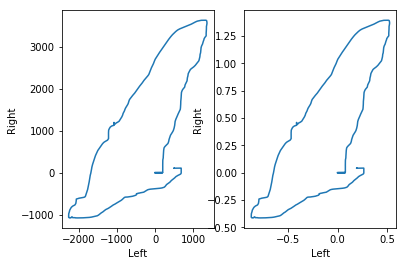

In [87]:

# Setup an array to store the encoder positions
left_motor = [] # initialize a empty list. You can add to a list with the left_motor.append(item) command
right_motor = [] # initialize an empty list

#different amplitude and phase combinations of your leg gait.    
left = m0.encoder.pll_pos - motor0_home
right = m1.encoder.pll_pos - motor1_home

t0 = time.monotonic()
t_stop = time.time() + 30

my_drive.config.brake_resistance = 0.0

#Turn off the motors
m0.config.pos_gain = 0.0;
m1.config.pos_gain = 0.0;

while True:
    time.sleep(0.01)
    
    left = (m0.encoder.pll_pos - motor0_home)
    right = (m1.encoder.pll_pos - motor1_home)
    
    left_motor.append(left)
    right_motor.append(right)
    
    if time.time() > t_stop:
        break

calibration = int(2048*4/math.pi)
   
# Plot the results using encoder values (centered on your new home) and scaled to be between -pi, pi
plt.subplot(1,2,1)
plt.plot(left_motor, right_motor)
plt.xlabel('Left')
plt.ylabel('Right')

plt.subplot(1,2,2)
plt.plot(np.array(left_motor) / calibration, np.array(right_motor) / calibration)
plt.xlabel('Left')
plt.ylabel('Right')



## Problem 5: Command a simple cyclic gait of the leg

__5.1__ In this last problem we will command a simple cyclic gait of the leg by sending sinusoidal position commands to the motors and exploring how phase and amplitude differences influence the foot motion. Record the encoder position while running the gait and provide plots of the motor angles as a function of time. Additionally, take a video of each gait and post it to youtube, including a link in the notebook at the very bottom. You can include youtube videos by entering the command ```YouTubeVideo('video_code')``` in a code cell, where video code is found from the youtube page.

*Provide plots and videos for three different gaits*


In [43]:
#Sinusoidal positions for different gaits
def sinus_motors(Amplitude_left, Amplitude_right, Phase_left, Phase_right, w):
    left_motor = [] 
    right_motor = []
    t = []

    initial_time = time.monotonic()  # record the current time
    current_time = time.monotonic() 

    m0.config.pos_gain = 20.0;
    m1.config.pos_gain = 20.0;

    while (current_time - initial_time) < 15:
        time.sleep(0.1)
    
        setpoint0 = Amplitude_left*math.sin(time.monotonic()*w-Phase_left)-motor0_home
        setpoint1 = Amplitude_right*math.sin(time.monotonic()*w-Phase_right)-motor1_home

        my_drive.motor0.set_pos_setpoint(setpoint0, 0.1, 0.5)
        my_drive.motor1.set_pos_setpoint(setpoint1, 0.1, 0.5)
    
        left = (m0.encoder.pll_pos-motor0_home)
        right = (m1.encoder.pll_pos-motor1_home)
    
        left_motor.append(left)
        right_motor.append(right)
    
        current_time = time.monotonic() 
        t.append(current_time)
    
    my_drive.motor0.set_pos_setpoint(motor0_home, 0.0, 0.0)
    my_drive.motor1.set_pos_setpoint(motor1_home, 0.0, 0.0)
    return (left_motor, right_motor, t)
    
    


In [100]:
Amplitude_left = 700
Amplitude_right = -700
Phase_left = 1
Phase_right = 3
w = 0.5*math.pi

(left_motor, right_motor, t) = sinus_motors(Amplitude_left, Amplitude_right, Phase_left, Phase_right, w)

plt.subplot(1,2,1)
plt.plot(t, left_motor)
plt.xlabel('time')
plt.ylabel('Left')

plt.subplot(1,2,2)
plt.plot(t, right_motor)
plt.xlabel('time')
plt.ylabel('Right')

Text(0,0.5,'Right')

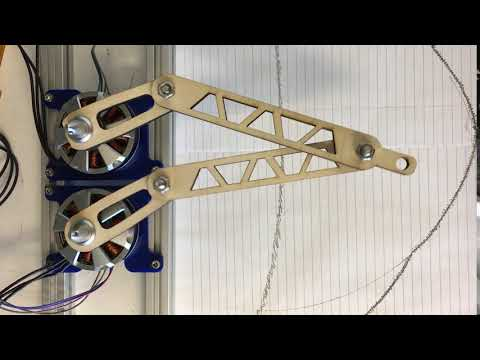

In [117]:

YouTubeVideo('iS9LEicsxY8')

In [102]:
Amplitude_left = 900
Amplitude_right = -1200
Phase_left = 20
Phase_right = 50
w = 0.8*math.pi

(left_motor, right_motor, t) = sinus_motors(Amplitude_left, Amplitude_right, Phase_left, Phase_right, w)

plt.subplot(1,2,1)
plt.plot(t, left_motor)
plt.xlabel('time')
plt.ylabel('Left')

plt.subplot(1,2,2)
plt.plot(t, right_motor)
plt.xlabel('time')
plt.ylabel('Right')

Text(0,0.5,'Right')

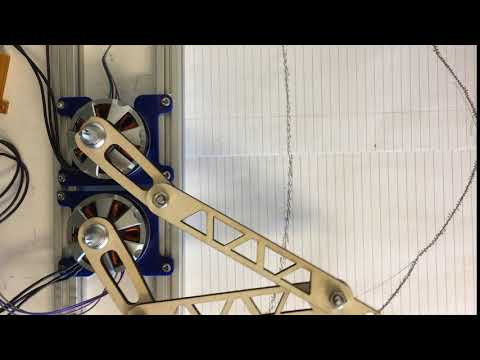

In [116]:
YouTubeVideo('wg_l13fLhyc')

In [105]:
Amplitude_left = 600
Amplitude_right = 600
Phase_left = 1
Phase_right = 0.5
w = 0.25*math.pi

(left_motor, right_motor, t) = sinus_motors(Amplitude_left, Amplitude_right, Phase_left, Phase_right, w)

plt.subplot(1,2,1)
plt.plot(t, left_motor)
plt.xlabel('time')
plt.ylabel('Left')

plt.subplot(1,2,2)
plt.plot(t, right_motor)
plt.xlabel('time')
plt.ylabel('Right')

Text(0,0.5,'Right')

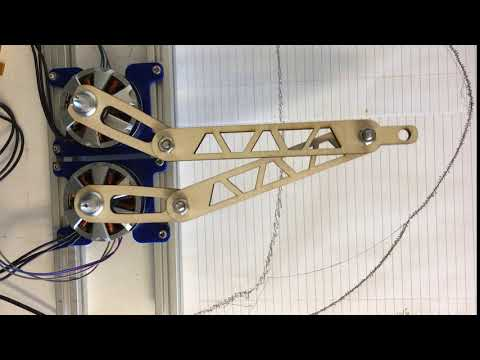

In [118]:
YouTubeVideo('gnML0jm8I-0')